In [49]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})
import seaborn as sns

%load_ext autoreload
%autoreload 2
package_path = r'E:\TMC\PRISM_Code\gene_calling'
if package_path not in sys.path: sys.path.append(package_path)


BASE_DIR = Path(r'F:\spatial_data\processed')
RUN_ID = '20240902_PRISM_64_Mouse_Brain_adjust_1'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
read_dir = src_dir / 'readout'
figure_dir = read_dir / 'figures'
os.makedirs(read_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data and preprocess

In [50]:
PRISM_PANEL = 'PRISM63' # 'PRISM30', 'PRISM31', 'PRISM63', 'PRISM64'
GLAYER = 3
COLOR_GRADE = 6
Q_CHANNELS = ['Ye/A', 'B/A', 'R/A',]
Q_NUM = int(COLOR_GRADE * (COLOR_GRADE + 1)/2)

# visualization
XRANGE = [-0.8, 0.8]
YRANGE = [-0.6, 0.8]

In [51]:
intensity_raw = pd.read_csv(read_dir / 'intensity_deduplicated.csv', index_col=0)

intensity = intensity_raw.copy()
intensity.head()

,Y,X,Channel,R,Ye,G,B,Scaled_R,Scaled_Ye,Scaled_G,Scaled_B,sum,G/A
0,17140,2383,cy5,16635,4555,1891,26251.25,16635,4555,4727.5,19688.4375,40879.4375,0.115645
1,3116,13071,cy5,15907,5736,2127,14768.25,15907,5736,5317.5,11076.1875,32720.1875,0.162514
2,5470,10148,cy5,13484,0,0,0.00,13484,0,0.0,0.0000,13485.0000,0.000000
3,9667,9646,cy5,11344,2481,2593,4390.75,11344,2481,6482.5,3293.0625,17119.0625,0.378671
4,9677,9656,cy5,10237,5072,1487,18483.25,10237,5072,3717.5,13862.4375,29172.4375,0.127432


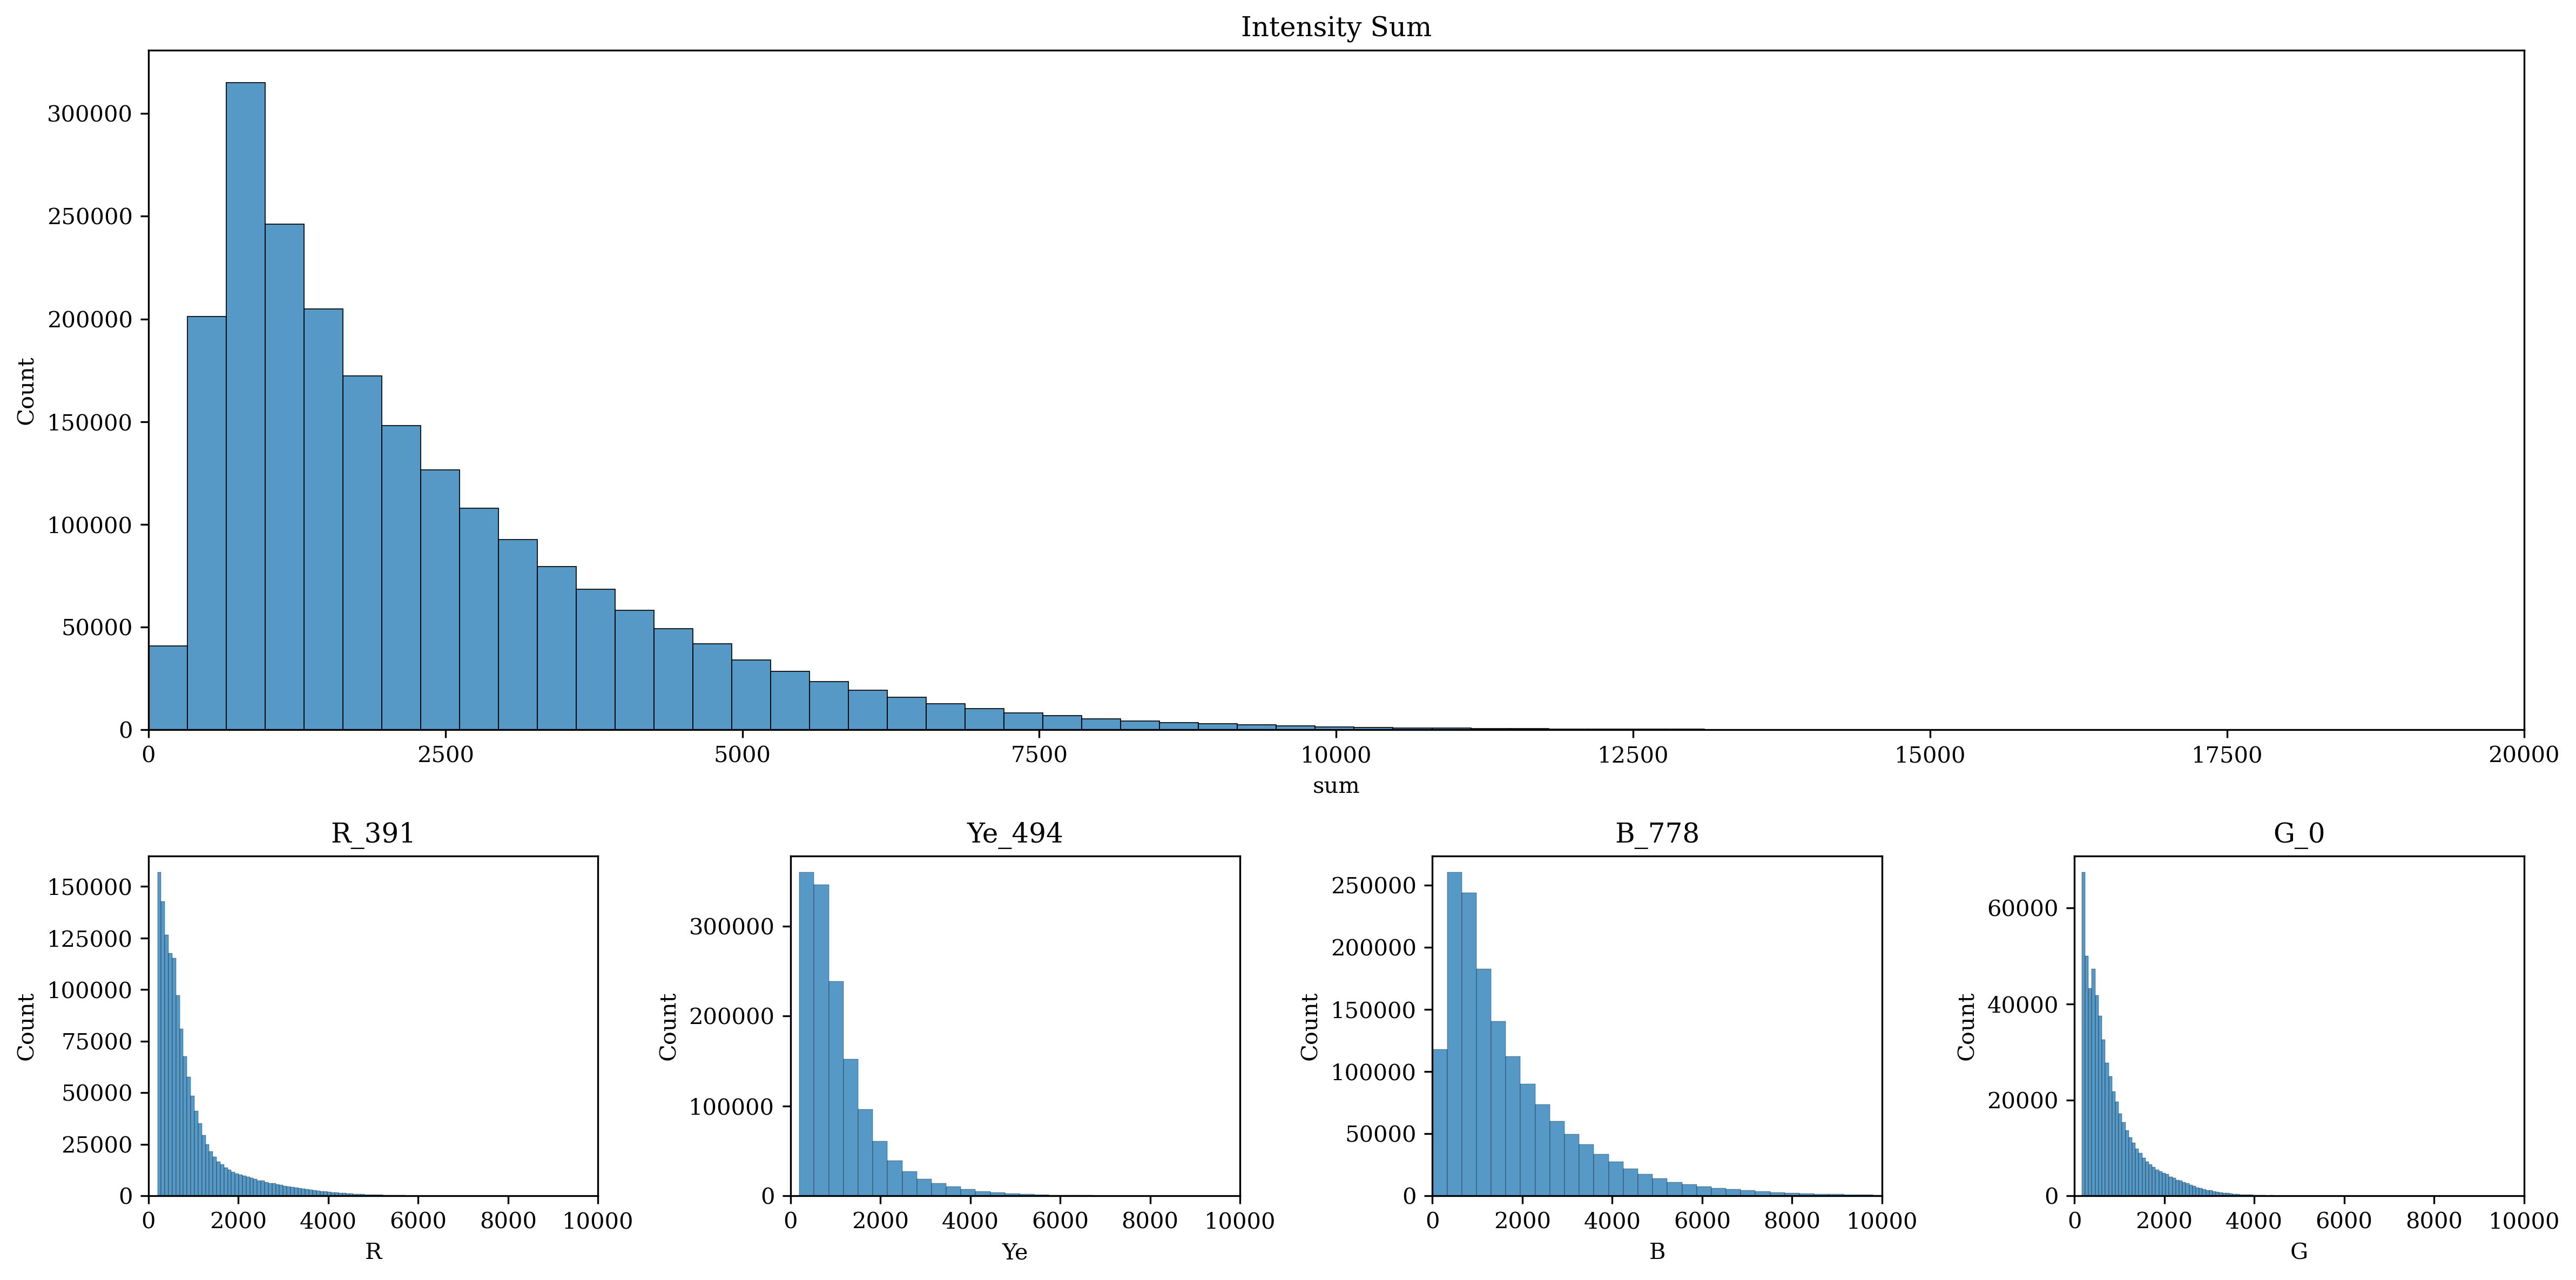

In [52]:
# set 1 subplot on the above and 4 on the below
# the above subplot is the histogram of intensity sum column
# the below subplots are the histogram of each channel
# use gridspec to make the 1 row one subplot
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 4, height_ratios=[2, 1])
ax0 = plt.subplot(gs[0,:])

sns.histplot(intensity['sum'], bins=200, ax=ax0)
ax0.set_xlim((0,20000))
ax0.set_title('Intensity Sum')

for i, channel in enumerate(['R','Ye','B','G']):
    ax = plt.subplot(gs[1, i])
    sns.histplot(intensity.loc[intensity[channel]>0, channel], bins=200, ax=ax)
    median = intensity[channel].median()
    ax.set_xlim((0,10000))
    ax.set_title(f'{channel}_{median:.0f}')

plt.tight_layout()
plt.savefig(figure_dir / 'intensity_dist_hist.png')
# plt.close()

## Overview of data distribution

In [53]:
intensity['sum'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B']
intensity = intensity[(intensity['sum']>500)&(intensity['sum']<8000)]
# intensity = intensity[intensity['sum']>2000]
intensity['Ye/A'] = intensity['Scaled_Ye'] / intensity['sum']
intensity['B/A'] = intensity['Scaled_B'] / intensity['sum']
intensity['R/A'] = intensity['Scaled_R'] / intensity['sum']
intensity['G/A'] = intensity['Scaled_G'] / intensity['sum']

# adjust of G_channel
intensity['G/A'] = np.log(1 + intensity['G/A']) / np.log(10)
if PRISM_PANEL in ('PRISM64', 'PRISM63'):
    intensity['G/A'] = np.log(1 + intensity['G/A']) / np.log(10)
    intensity['G/A'] = intensity['G/A'] * 3

# intensity.loc[intensity['G/A']>3, 'G/A'] = 3
# intensity['G/A'] = np.log1p(intensity['G/A']) 
# intensity['G/A'] = intensity['G/A'] * np.exp(0.6 * intensity['Ye/A'])

intensity_G = intensity[intensity['G/A'].isna()]
intensity = intensity[~intensity.index.isin(intensity_G.index)]

if PRISM_PANEL in ('PRISM31', 'PRISM64'):
    if PRISM_PANEL == 'PRISM31': THRE = 1.5
    elif PRISM_PANEL == 'PRISM64': THRE = 1.5
    intensity_G = pd.concat([intensity_G, intensity[intensity['G/A'] > THRE]])
    intensity = intensity[~intensity.index.isin(intensity_G.index)]
    intensity_G

In [54]:
RYB_x_transform = np.array([[-np.sqrt(2)/2], [np.sqrt(2)/2], [0]])
RYB_y_transform = np.array([[-1/2], [-1/2], [np.sqrt(2)/2]])
RYB_xy_transform = np.concatenate([RYB_x_transform, RYB_y_transform], axis=1)
intensity['X_coor'] = intensity[Q_CHANNELS] @ RYB_x_transform
intensity['Y_coor'] = intensity[Q_CHANNELS] @ RYB_y_transform

In [55]:
data = intensity.copy()
# data = data.sample(10000)
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(7,5))
ax[0].hist(bins=100, x=data['Ye/A'])
ax[1].hist(bins=100, x=data['B/A'])
ax[2].hist(bins=100, x=data['R/A'])
ax[3].hist(bins=100, x=data['G/A'])

plt.savefig(figure_dir / 'histogram_raw.png', dpi=300, bbox_inches='tight')
plt.close()

## Gaussian blur and orthogonal decomposition

In [56]:
# blur at position 0
gaussian = np.concatenate([np.random.normal(loc=0, scale=0.01, size=intensity[Q_CHANNELS].shape), 
                           np.random.normal(loc=0, scale=0.01, size=intensity[['G/A']].shape)], axis=1)
intensity[Q_CHANNELS + ['G/A']] = intensity[Q_CHANNELS + ['G/A']].mask(intensity[Q_CHANNELS + ['G/A']]==0, gaussian)

# blur at position 1
gaussian = np.random.normal(loc=0, scale=0.01, size=intensity[Q_CHANNELS].shape)
intensity[Q_CHANNELS] = intensity[Q_CHANNELS].mask(intensity[Q_CHANNELS]==1, 1 + gaussian)

intensity['X_coor_gaussian'] = intensity[Q_CHANNELS] @ RYB_x_transform
intensity['Y_coor_gaussian'] = intensity[Q_CHANNELS] @ RYB_y_transform

## Overview of preprocessed data distribution

In [57]:
from scipy.signal import argrelextrema


def plot_hist_with_extrema(a, ax=None, bins=100, extrema='max', kde_kws={'bw_adjust':0.5}):
    sns.histplot(a, bins=bins, stat='count', edgecolor='white', alpha=1, ax=ax, kde=True, kde_kws=kde_kws)
    y = ax.get_lines()[0].get_ydata()
    if extrema == 'max':
        y = -y
    extrema = [float(_/len(y)*(max(a)-min(a))+min(a)) for _ in argrelextrema(np.array(y), np.less)[0]]
    for subextrema in extrema:
        ax.axvline(x=subextrema, color='r', alpha=0.5, linestyle='--')
    return extrema

# data = intensity.copy()
data = intensity.sample(200000)
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(7, 7))
plt.setp(ax, xlim=(-0.25, 1.2))
Y_maxima = plot_hist_with_extrema(data['Ye/A'], ax=ax[0], extrema='max', kde_kws={'bw_adjust':1.6})
B_maxima = plot_hist_with_extrema(data['B/A'], ax=ax[1], extrema='max', kde_kws={'bw_adjust':1})
R_maxima = plot_hist_with_extrema(data['R/A'], ax=ax[2], extrema='max', kde_kws={'bw_adjust':1})
G_minima = plot_hist_with_extrema(data['G/A'], ax=ax[3], extrema='min', kde_kws={'bw_adjust':2})

if len(Y_maxima) != COLOR_GRADE: Y_maxima = [(_) / (COLOR_GRADE-1) for _ in range(COLOR_GRADE)]
if len(B_maxima) != COLOR_GRADE: B_maxima = [(_) / (COLOR_GRADE-1) for _ in range(COLOR_GRADE)]
if len(R_maxima) != COLOR_GRADE: R_maxima = [(_) / (COLOR_GRADE-1) for _ in range(COLOR_GRADE)]

plt.savefig(figure_dir / 'histogram.png', dpi=300, bbox_inches='tight')
plt.close()

In [58]:
minima = G_minima.copy()
minima = minima[: GLAYER - 1]
minima.insert(0, intensity['G/A'].min()-0.01)
minima.append(intensity['G/A'].max()+0.01)

intensity['G_layer'] = pd.cut(intensity['G/A'], bins=minima, labels=[_ for _ in range(len(minima)-1)], include_lowest=True, right=False)

In [59]:
def ybrg_to_rgb(ybr, g=0):
    y, b, r = ybr
    red = y + r
    green = 0.9 * y + 0.2 * g
    blue = b
    return ((red, green, blue) / np.max((red, green, blue))).clip(0, 1)

def reorder(array, order='PRISM30'):
    if order == 'PRISM30' or order == 'PRISM31':
        relabel = {1:1, 2:6, 3:10, 4:13, 5:15, 6:14, 7:12, 8:9, 9:5, 10:4, 11:3, 12:2, 13:7, 14:11, 15:8}
    elif order == 'PRISM63' or order == 'PRISM64':
        relabel = {1:1, 2:7, 3:12, 4:16, 5:19, 6:21, 7:20, 8:18, 9:15, 10:11, 11:6, 
                     12:5, 13:4, 14:3, 15:2, 16:8, 17:13, 18:9, 19:17, 20:14, 21:10}
    else:print('Undefined order, use PRISM30 or PRISM63 instead.')
    return np.array([array[relabel[_]-1] for _ in relabel])

In [60]:
# preparation for init centroids
import itertools

centroid_init_dict = dict()
colormap = dict()

fig, ax =  plt.subplots(nrows=3, ncols=GLAYER, figsize=(20, 10))
for layer in range(GLAYER):
    data = intensity[intensity['G_layer'] == layer]
    data = data.sample(min(100000, len(data)))
    ax_tmp = ax if GLAYER < 2 else ax[:, layer]
    ax_tmp[0].set_title(f'G_layer{layer}')
    Y_maxima_tmp = plot_hist_with_extrema(data['Ye/A'], ax=ax_tmp[0], extrema='max', kde_kws={'bw_adjust':0.8})
    B_maxima_tmp = plot_hist_with_extrema(data['B/A'], ax=ax_tmp[1], extrema='max', kde_kws={'bw_adjust':0.9})
    R_maxima_tmp = plot_hist_with_extrema(data['R/A'], ax=ax_tmp[2], extrema='max', kde_kws={'bw_adjust':0.7})

    if len(R_maxima_tmp) != COLOR_GRADE: R_maxima_tmp = R_maxima
    if len(Y_maxima_tmp) != COLOR_GRADE: Y_maxima_tmp = Y_maxima
    if len(B_maxima_tmp) != COLOR_GRADE: B_maxima_tmp = B_maxima

    combinations = itertools.product(range(0, COLOR_GRADE), repeat=3)
    filtered_combinations = filter(lambda x: sum(x) == COLOR_GRADE - 1, combinations)
    centroid_init_dict[layer] = np.array([[Y_maxima_tmp[_[0]], B_maxima_tmp[_[1]], R_maxima_tmp[_[2]],] for _ in filtered_combinations])
    centroid_init_dict[layer] = reorder(centroid_init_dict[layer], order=PRISM_PANEL)
    color_list = [ybrg_to_rgb(_, g=layer/GLAYER) for _ in centroid_init_dict[layer]]
    colormap[layer] = {layer*Q_NUM + i + 1:color_list[i] for i in range(len(color_list))}

plt.savefig(figure_dir / 'histogram_by_layer.png', dpi=300, bbox_inches='tight')
plt.close()

In [61]:
s = 0.009
alpha = 0.08
percentile_thre = 99.5
bins = (500, 500)

n_rows = 2
n_cols = 2 + GLAYER
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols + 2, 10))
ax[1,0].scatter(intensity['X_coor_gaussian'], intensity['G/A'], s=s, alpha=alpha, linewidths=None)
ax[1,0].set_ylim([-0.2,1.4])
ax[0,1].scatter(intensity['Y_coor_gaussian'], intensity['G/A'], s=s, alpha=alpha, linewidths=None)
ax[0,1].set_ylim([-0.2,1.4])
ax[0,0].scatter(intensity['X_coor_gaussian'], intensity['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)
ax[0,0].set_xlim(XRANGE)
ax[0,0].set_ylim(YRANGE)


for subextrema in minima: ax[1,0].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')
for subextrema in minima: ax[0,1].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')

for layer in range(GLAYER):
    ax_scatter = ax[0, 2+layer]
    ax_hist = ax[1, 2+layer]
    # sub = intensity[(intensity['sum']>1000)&(intensity['sum']<15000)&(intensity['G_layer']==layer)]
    sub = intensity[intensity['G_layer']==layer]
    ax_scatter.set_title(f'G={layer}')
    ax_scatter.scatter(sub['X_coor_gaussian'], sub['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)
    ax_scatter.set_xlim(XRANGE)
    ax_scatter.set_ylim(YRANGE)

    x, y = sub['X_coor_gaussian'], sub['Y_coor_gaussian']
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    percentile = np.percentile(hist, percentile_thre)
    ax_hist.hist2d(x, y, bins=bins, vmax=percentile,
                   range=[XRANGE, YRANGE], cmap='inferno')
    ax_hist.set_xlim(XRANGE)
    ax_hist.set_ylim(YRANGE)
    
plt.savefig(figure_dir / 'ColorSpace_overview.png', dpi=300, bbox_inches='tight')
plt.close()

In [15]:
gap_l = 0
gap_r = 0
for division in minima[1: GLAYER]: intensity = intensity[(intensity['G/A']<division-gap_l)|(intensity['G/A']>division+gap_r)]

In [16]:
s=0.009
alpha=0.08
percentile_thre = 99.5
bins = (500, 500)

n_rows = 2
n_cols = 2 + GLAYER
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols + 2, 10))
ax[1,0].scatter(intensity['X_coor_gaussian'], intensity['G/A'], s=s, alpha=alpha, linewidths=None)
ax[1,0].set_ylim([-0.2,1.4])
ax[0,1].scatter(intensity['Y_coor_gaussian'], intensity['G/A'], s=s, alpha=alpha, linewidths=None)
ax[0,1].set_ylim([-0.2,1.4])
ax[0,0].scatter(intensity['X_coor_gaussian'], intensity['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)
ax[0,0].set_xlim(XRANGE)
ax[0,0].set_ylim(YRANGE)


for subextrema in minima: ax[1,0].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')
for subextrema in minima: ax[0,1].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')

for layer in range(GLAYER):
    ax_scatter = ax[0, 2+layer]
    ax_hist = ax[1, 2+layer]
    sub = intensity[intensity['G_layer']==layer]
    # sub = intensity[(intensity['sum']>1000)&(intensity['sum']<15000)&(intensity['G_layer']==layer)]
    ax_scatter.set_title(f'G={layer}')
    ax_scatter.scatter(sub['X_coor_gaussian'], sub['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)
    ax_scatter.set_xlim(XRANGE)
    ax_scatter.set_ylim(YRANGE)

    x, y = sub['X_coor_gaussian'], sub['Y_coor_gaussian']
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    percentile = np.percentile(hist, percentile_thre)
    ax_hist.hist2d(x, y, bins=bins, vmax=percentile,
                   range=[XRANGE, YRANGE], cmap='inferno')
    ax_hist.set_xlim(XRANGE)
    ax_hist.set_ylim(YRANGE)
plt.savefig(figure_dir / 'ColorSpace_G_thre.png', dpi=300, bbox_inches='tight')
plt.close()

## Projection of density in 3D

In [17]:
from scipy import stats


if (read_dir / 'tmp' / 'density.bin').exists(): 
    x, y, z = np.fromfile(read_dir / 'tmp' / 'x.bin'), np.fromfile(read_dir / 'tmp' / 'y.bin'), np.fromfile(read_dir / 'tmp' / 'z.bin')
    density = np.fromfile(read_dir / 'density.bin')
else:
    data = intensity.sample(min(1000000, len(intensity)))
    x = np.array(data['X_coor_gaussian'])
    y = np.array(data['Y_coor_gaussian'])
    z = np.array(data['G/A'])
    xyz = np.vstack([x,y,z])
    density = stats.gaussian_kde(xyz)(xyz) 
    x.tofile(read_dir / 'tmp' / 'x.bin')
    y.tofile(read_dir / 'tmp' / 'y.bin')
    z.tofile(read_dir / 'tmp' / 'z.bin')
    density.tofile(read_dir / 'tmp' / 'density.bin')

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density, cmap=plt.cm.gnuplot2, vmin=0, s=0.1, alpha=0.3, marker='o', edgecolor='none')
ax.set_zlim3d(-0.1, 0.8)
ax.view_init(elev=30, azim=270)
fig.set_facecolor('black')
ax.set_facecolor('black') 
ax.grid(False) 
ax.set_axis_off()
plt.savefig(figure_dir / 'ColorSpace_3D_density.png', dpi=300, bbox_inches='tight')
plt.close()

# separation by GMM

In [18]:
from sklearn.mixture import GaussianMixture as GMM


def apply_gmm(reduced_features, num_clusters, means_init=None):
    gmm = GMM(n_components=num_clusters, covariance_type='diag', means_init=means_init)
    gmm_clusters = gmm.fit(reduced_features)
    labels = gmm_clusters.predict(reduced_features)
    return  gmm_clusters, labels

intensity['label'] = -1
GMM_dict = dict()
for layer in range(GLAYER):
    centroids_init = centroid_init_dict[layer]
    filtered_data = intensity[intensity['G_layer'] == layer]
    reduced_features = filtered_data[Q_CHANNELS]
    gmm, gmm_labels = apply_gmm(reduced_features, num_clusters=len(centroids_init), means_init=centroids_init)
    GMM_dict[layer] = gmm 
    intensity.loc[filtered_data.index, 'label'] = gmm_labels + int(layer * Q_NUM + 1)

In [19]:
bins = (500, 500)
percentile_thre = 98

fig, ax = plt.subplots(nrows=2, ncols=GLAYER, figsize=(5.5 * GLAYER, 10))
for layer in range(GLAYER):
    ax_gmm = ax[0] if GLAYER < 2 else ax[0, layer]
    ax_hist = ax[1] if GLAYER < 2 else ax[1, layer]
    data = intensity[intensity['G_layer'] == layer]
    data = data[data['label'] != -1]
    gmm = GMM_dict[layer]
    
    # ax_gmm.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], c=data['label'], marker='.', alpha=0.1, s=0.1)
    ax_gmm.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], label=data['label'],
                   c=[colormap[layer][label] for label in data['label']], marker='.', alpha=alpha, s=s)
    for i in range(1 + layer * Q_NUM, 1 + (layer+1) * Q_NUM):
        cen_tmp = np.mean(data[data['label']==i][['X_coor_gaussian', 'Y_coor_gaussian']], axis=0)
        ax_gmm.text(cen_tmp[0], cen_tmp[1], i, fontsize=12, color='black', ha='center', va='center')
    RYB_xy_transform = np.concatenate([RYB_x_transform, RYB_y_transform], axis=1)
    centroid_init = centroid_init_dict[layer] @ RYB_xy_transform
    ax_gmm.scatter(centroid_init[:, 0], centroid_init[:, 1], color='cyan', s=1.5, alpha=0.7)

    ax_gmm.set_title(f'G={layer}')
    ax_gmm.set_xlim(XRANGE)
    ax_gmm.set_ylim(YRANGE)

    x, y = data['X_coor_gaussian'], data['Y_coor_gaussian']
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    percentile = np.percentile(hist, percentile_thre)
    ax_hist.hist2d(x, y, bins=bins, vmax=percentile,
                   range=[XRANGE, YRANGE], cmap='inferno')
    ax_hist.set_xlim(XRANGE)
    ax_hist.set_ylim(YRANGE)

axes = ax.flat
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(figure_dir / f'{i//GLAYER+1}-layer{i%GLAYER+1}.png', bbox_inches=bbox)

plt.tight_layout()
plt.savefig(figure_dir / 'ColorSpace_GMM.png', dpi=300)
plt.close()

## manual check

In [ ]:
import cv2
from lib.manual_thre import draw_mask_manual

# Adjust mask
mask_check_dir = read_dir / 'mask_check'
mask_check_dir.mkdir(exist_ok=True)
draw_mask_manual(image_path=str(read_dir / 'figures' / '2-layer3.png'),
                 mask_path=str(read_dir / 'mask_check' / 'mask_63.png'))

In [ ]:
intensity_check = intensity[['Y','X','X_coor_gaussian', 'Y_coor_gaussian', 'G/A', 'G_layer', 'label']]

# Adjust G
# intensity_check['check_G_layer'] = intensity_check['G_layer']
# adjusted_G = intensity_check[(intensity_check['G/A']>0.5)&(intensity_check['G/A']<1)]
# intensity_check.loc[adjusted_G.index, 'check_G_layer'] = 1

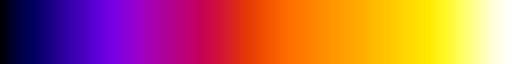

In [ ]:
from lib.projection import generate_colormap

cmap_fire = generate_colormap('imagej:fire')
cmap_fire

In [ ]:
import matplotlib
from lib.manual_thre import relabel_mask
from lib.projection import plot_params_generator, customize_axis, projection_gene


plot_params = plot_params_generator(x=intensity_check['X'], y=intensity_check['Y'], downsample_factor=100, edge=0.05)

# 设置画布 
fig_height_inch = plot_params['fig_height_inch']
main_plot_width_inch = plot_params['main_plot_width_inch']
cbar_width_inch = plot_params['cbar_width_inch']
gap_width_inch = 1
full_height_inch = fig_height_inch + 2 * gap_width_inch
full_width_inch = main_plot_width_inch + fig_height_inch-gap_width_inch + cbar_width_inch + 3 * gap_width_inch
grid_resolution = 100
spots_color = 'lightblue'
select_spot_color = 'red'

In [ ]:
# 保存图片
density_dir = read_dir / 'density_check'
density_dir.mkdir(exist_ok=True)
label_list = [_.split('_')[-1].split('.')[0] for _ in os.listdir(mask_check_dir) if _.endswith('.png')]

for label in tqdm(label_list):
    intensity_check = intensity[['Y','X','X_coor_gaussian', 'Y_coor_gaussian', 'G/A', 'G_layer', 'label']]
    for label in tqdm(label_list):
        mask = cv2.imread(os.path.join(mask_check_dir, f"mask_{label}.png"), cv2.IMREAD_GRAYSCALE).astype(bool)
        glayer = (int(label.split('-')[0])-1) // Q_NUM
        intensity_check = relabel_mask(
            intensity=intensity_check, mask=mask, xlim=XRANGE,ylim=YRANGE,
            ch_label=label, mode='replace', G_layer=glayer)

    intensity_select = intensity_check[intensity_check['label']==label]
    glayer = (int(label.split('-')[0])-1) // Q_NUM

    fig = plt.figure(figsize=(full_width_inch, full_height_inch))
    fig.set_facecolor('black')
    one_cubic_num = int((fig_height_inch-gap_width_inch)*grid_resolution/2)
    r_width_num = int(main_plot_width_inch * grid_resolution)
    cbar_num = int(cbar_width_inch * grid_resolution)
    gap_width_num = int(gap_width_inch * grid_resolution)

    gs = fig.add_gridspec(2*one_cubic_num+3*gap_width_num, 2*one_cubic_num + 4*gap_width_num + r_width_num + cbar_num)
    ax_lu = fig.add_subplot(gs[gap_width_num: one_cubic_num+gap_width_num, gap_width_num: one_cubic_num+gap_width_num], projection='3d')
    ax_lu.set_axis_off()
    ax_lb = fig.add_subplot(gs[one_cubic_num+2*gap_width_num: 2*one_cubic_num+2*gap_width_num, gap_width_num: one_cubic_num+gap_width_num])
    ax_ru = fig.add_subplot(gs[gap_width_num: one_cubic_num+gap_width_num, one_cubic_num+2*gap_width_num: 2*one_cubic_num+2*gap_width_num])
    ax_rb = fig.add_subplot(gs[one_cubic_num+2*gap_width_num: 2*one_cubic_num+2*gap_width_num, one_cubic_num+2*gap_width_num: 2*one_cubic_num+2*gap_width_num])
    ax_r = fig.add_subplot(gs[gap_width_num: 2*one_cubic_num+2*gap_width_num, 2*one_cubic_num+4*gap_width_num: 2*one_cubic_num+4*gap_width_num+r_width_num])
    cax = fig.add_subplot(gs[gap_width_num: 2*one_cubic_num+2*gap_width_num, 2*one_cubic_num+4*gap_width_num+r_width_num: 2*one_cubic_num+4*gap_width_num+r_width_num+cbar_num])

    # Customizing each subplot
    customize_axis(ax_lu)
    customize_axis(ax_lb)
    customize_axis(ax_ru)
    customize_axis(ax_rb)
    customize_axis(ax_r)
    customize_axis(cax)

    # left upper
    x = intensity_check['X_coor_gaussian']
    y = intensity_check['Y_coor_gaussian']
    z = intensity_check['G/A']
    ax_lu.scatter(x, y, z, c=spots_color, marker='.', s=s, alpha=alpha, linewidths=None)
    x_select = intensity_select['X_coor_gaussian']
    y_select = intensity_select['Y_coor_gaussian']
    z_select = intensity_select['G/A']
    ax_lu.scatter(x_select, y_select, z_select, c=select_spot_color, marker='.', s=s, alpha=min(1,5*alpha), linewidths=None)
    ax_lu.set_xlim(XRANGE)
    ax_lu.set_ylim(YRANGE)
    ax_lu.set_zlim([-0.2,1])
    ax_lu.view_init(elev=20, azim=-70) 

    # left bottom    
    ax_lb.scatter(intensity_check['X_coor_gaussian'], intensity_check['G/A'], s=s, alpha=alpha, color=spots_color, linewidths=None)
    ax_lb.scatter(intensity_select['X_coor_gaussian'], intensity_select['G/A'], s=s, alpha=min(1,2*alpha), color=select_spot_color, linewidths=None)
    ax_lb.set_ylim([-0.2,1.4])

    # right upper
    ax_ru.scatter(intensity_check['Y_coor_gaussian'], intensity_check['G/A'], s=s, alpha=alpha, color=spots_color, linewidths=None)
    ax_ru.scatter(intensity_select['Y_coor_gaussian'], intensity_select['G/A'], s=s, alpha=min(1,2*alpha), color=select_spot_color, linewidths=None)
    ax_ru.set_ylim([-0.2,1.4])

    # right bottom
    intensity_layer = intensity_check[intensity_check['G_layer']==glayer]
    ax_rb.scatter(intensity_layer['X_coor_gaussian'], intensity_layer['Y_coor_gaussian'], s=s, alpha=alpha, color=spots_color, linewidths=None)
    ax_rb.scatter(intensity_select['X_coor_gaussian'], intensity_select['Y_coor_gaussian'], s=s, alpha=min(1,2*alpha), color=select_spot_color, linewidths=None)
    ax_rb.set_xlim(XRANGE)
    ax_rb.set_ylim(YRANGE)
    ax_rb.set_title(f'G={glayer}')

    # right: projection
    plot_params['ax'] = ax_r
    hist_im = projection_gene(x=intensity_select['X'], y=intensity_select['Y'], 
                              gene_name=label, plot_params_update=plot_params,)
    # right: colorbar
    cbar = plt.colorbar(hist_im, cax=cax)
    cbar.set_label('Counts', color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.ax.yaxis.set_tick_params(labelcolor='white')
    cbar.formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{round(x,1)}')
    cbar.update_ticks()

    plt.savefig(density_dir / f'{label}.png', dpi=300, bbox_inches='tight')
    plt.close()

## manual revise using mask

In [21]:
# from lib.manual_thre import draw_mask_manual

# os.makedirs(read_dir / 'masks', exist_ok=True)
# draw_mask_manual(image_path = str(read_dir / 'figures' / '2-layer1.png'),
#                   mask_path = str(read_dir / 'masks' / 'mask_29.png'),)

In [22]:
from lib.manual_thre import relabel

print(len(intensity_raw))
print(len(intensity))
intensity = relabel(intensity, mask_dir=read_dir/'mask_check', mode='replace', num_per_layer=Q_NUM, xrange=XRANGE, yrange=YRANGE)
intensity = relabel(intensity, mask_dir=read_dir/'mask_check', mode='discard', num_per_layer=Q_NUM, xrange=XRANGE, yrange=YRANGE)
print(len(intensity))

2657886
2508371


Relabeling, mode=discard: 100%|██████████| 30/30 [00:12<00:00,  2.38it/s]

2232412


### visualization


In [23]:
def visualization(intensity_fra,
                  G_layer=3,
                  num_per_layer=21,
                  bins = [100, 100],
                  percentile_thre=90,
                  XRANGE=[-0.8, 0.8],
                  YRANGE=[-0.6, 0.8],
                  out_path_dir=None,
                  colormap_dict=None,
                  label=True,):
    
    s = 1 / np.log2(len(intensity_fra)) *5
    alpha = 1 / np.log2(len(intensity_fra)) 

    fig, ax = plt.subplots(nrows=2, ncols=G_layer, figsize=(5.5 * G_layer, 10))
    for layer in tqdm(range(G_layer)):
        data = intensity_fra[intensity_fra['G_layer'] == layer]
        x, y = data['X_coor_gaussian'], data['Y_coor_gaussian']
        ax_scatter = ax[0] if G_layer < 2 else ax[0, layer]
        if label and colormap_dict: 
            colormap = [colormap_dict[layer][label] for label in data['label']]
            ax_scatter.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], c=colormap, label=data['label'], marker='.', alpha=alpha, s=s)
        elif label:
            ax_scatter.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], c=data['label'], marker='.', alpha=alpha, s=s)
            for i in range(1 + layer * num_per_layer, 1 + (layer+1) * num_per_layer):
                data_tmp = data[data['label']==i]
                cen_tmp = np.mean(data_tmp[['X_coor_gaussian', 'Y_coor_gaussian']], axis=0)
                ax_scatter.text(cen_tmp[0], cen_tmp[1], i, fontsize=12, color='black', ha='center', va='center')
        else: ax_scatter.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], marker='.', alpha=alpha, s=s)

        ax_scatter.set_xlim(XRANGE)
        ax_scatter.set_ylim(YRANGE)
        ax_scatter.set_title(f'G={layer}')


        ax_density = ax[1] if G_layer < 2 else ax[1, layer]
        hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
        percentile = np.percentile(hist, percentile_thre)
        ax_density.hist2d(x, y, bins=bins, vmax=percentile, range=[XRANGE, YRANGE], cmap='inferno')

    plt.tight_layout()
    if out_path_dir == None: plt.show()
    else: plt.savefig(out_path_dir, bbox_inches = 'tight')
    plt.close()

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


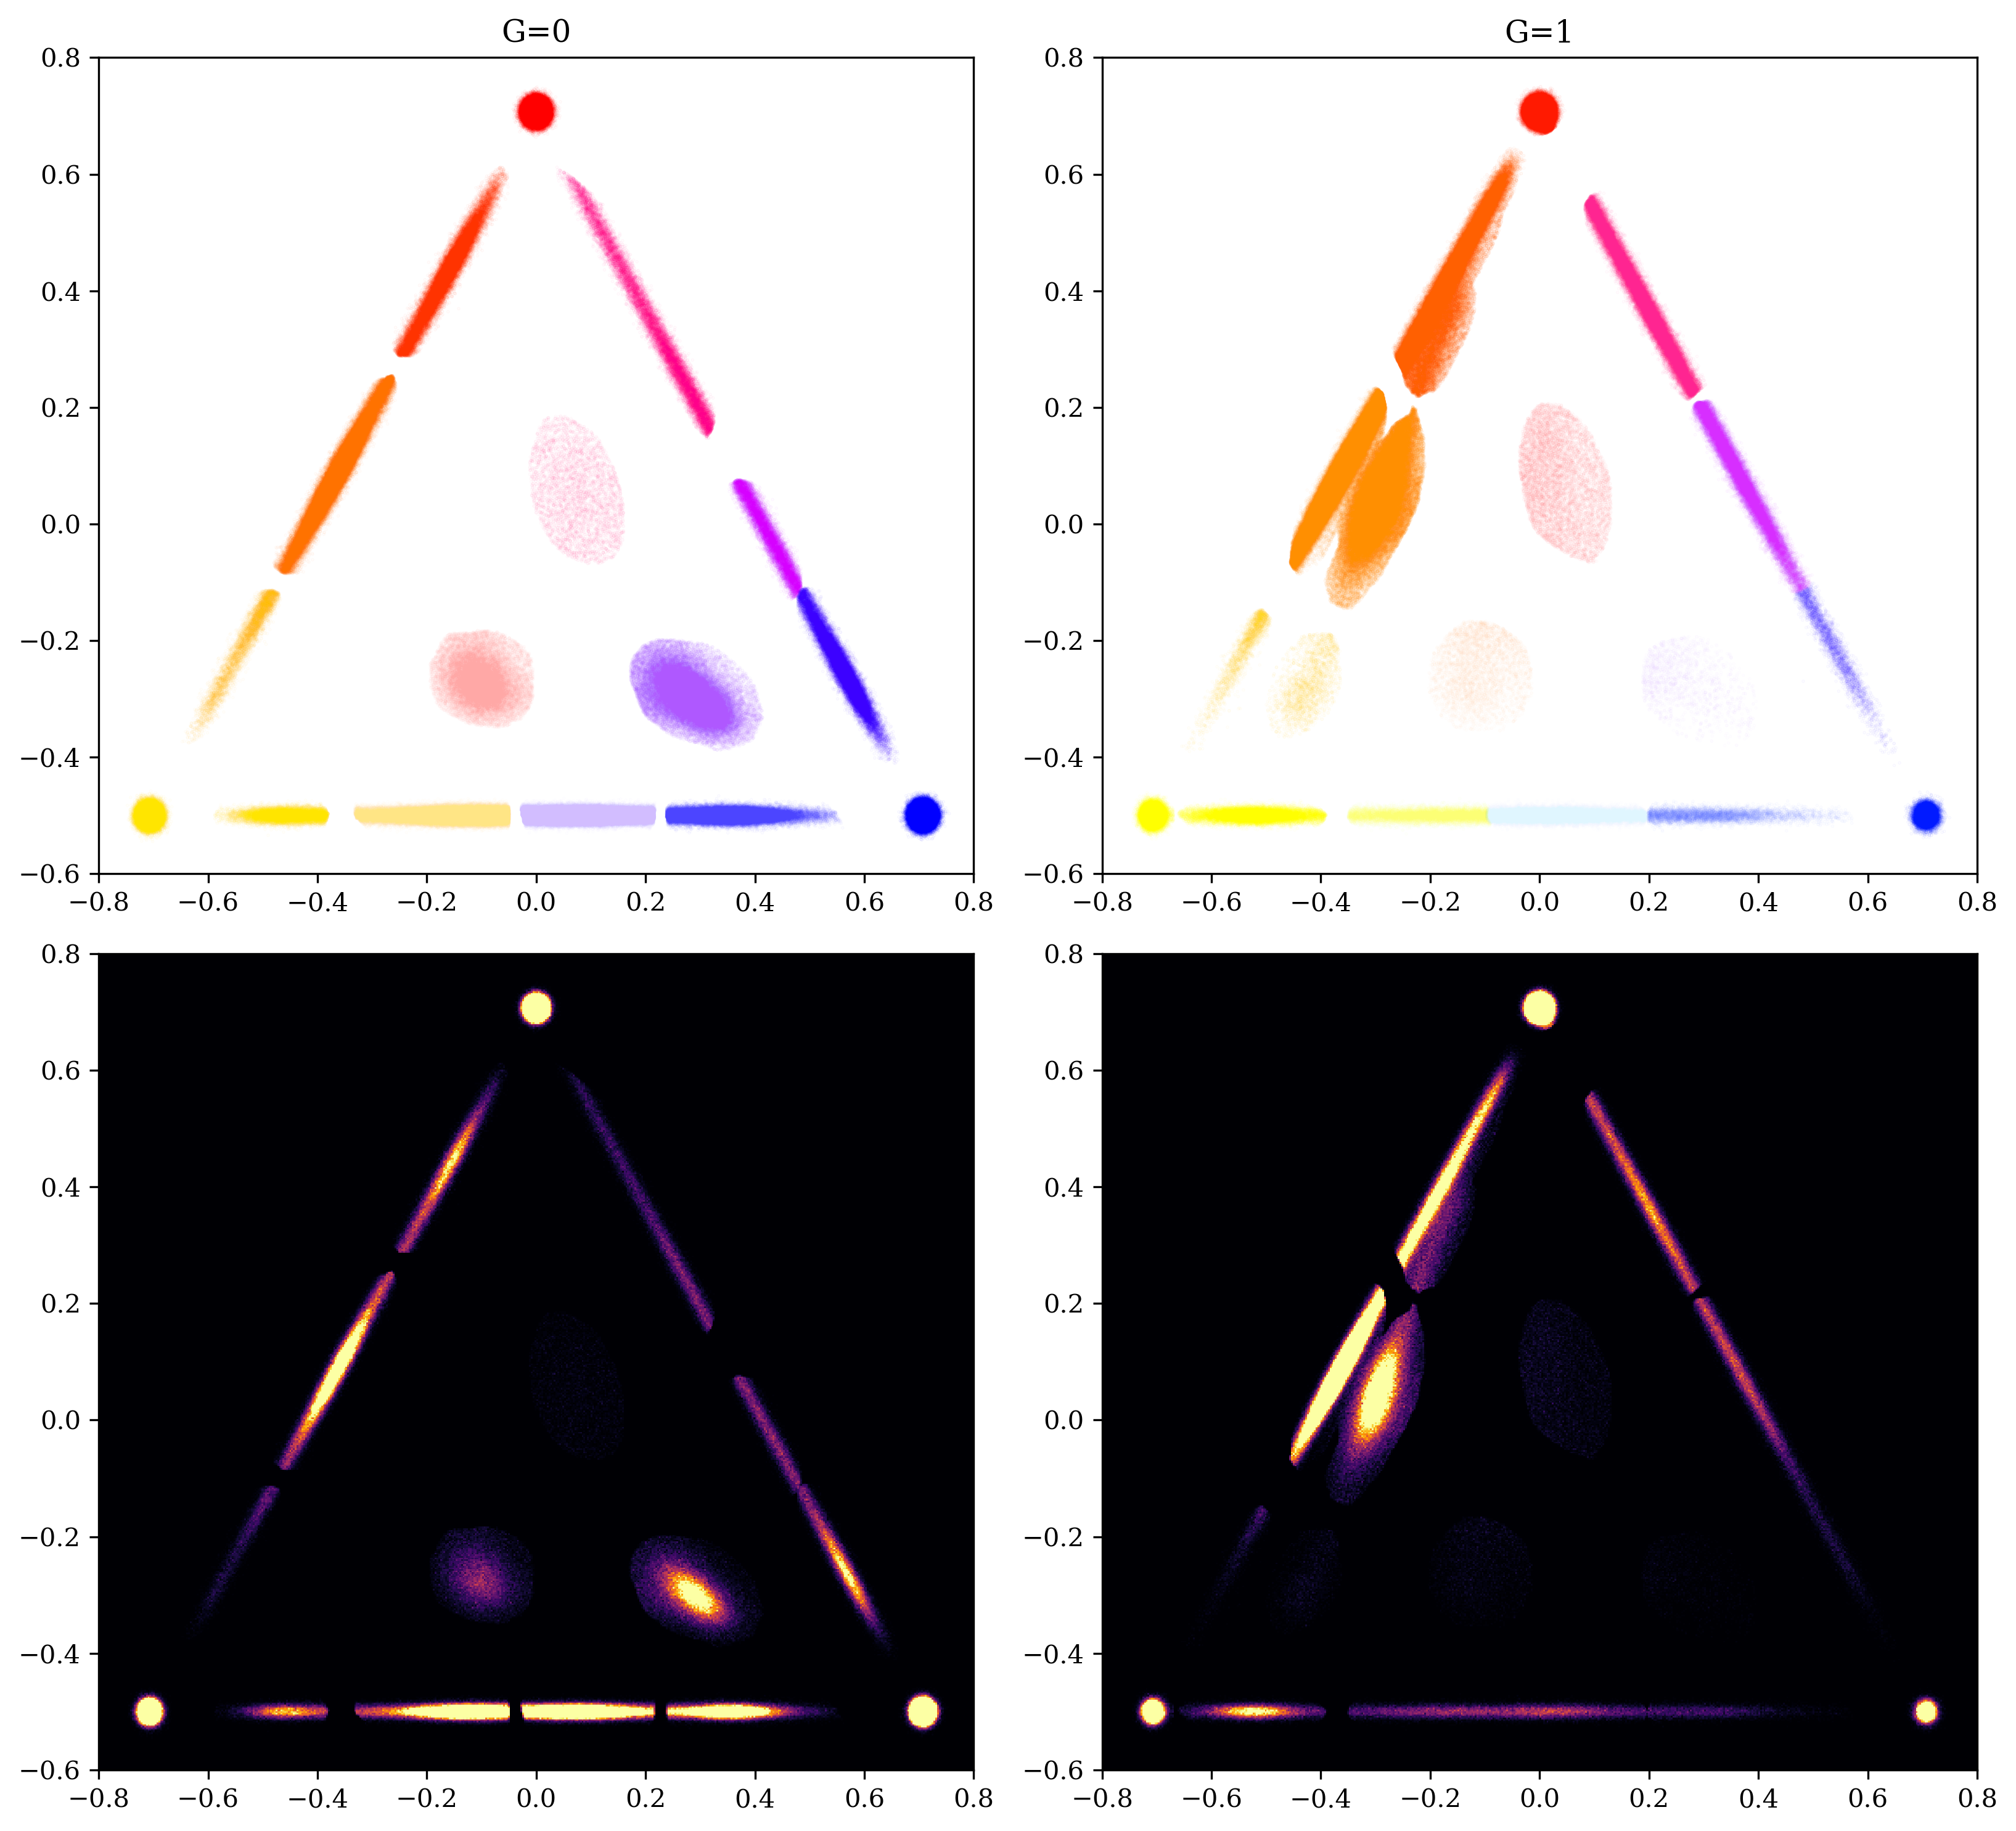

In [24]:
visualization(intensity, G_layer=GLAYER, num_per_layer=Q_NUM, 
              bins=[500, 500], percentile_thre=99, colormap_dict=colormap, 
              XRANGE=XRANGE, YRANGE=YRANGE)

# Quantitative analysis of GMM cluster quality

## cluster points num distribution

In [25]:
data = intensity.copy()
plt.figure(figsize=(Q_NUM * GLAYER / 3, 5))
sns.barplot(x = [cluster_num + 1 for cluster_num in range(Q_NUM * GLAYER)], 
            y = [len(data[data['label']==cluster_num+1]) for cluster_num in range(Q_NUM * GLAYER)])
plt.savefig(figure_dir / 'cluster_size.png', dpi=300, bbox_inches='tight')
plt.close()

## cdf related analysis

In [26]:
from tqdm import tqdm
from scipy import stats
import numpy as np


def calculate_cdf_gmm(X_sub, gmm, st):
    X_sub_cal = X_sub[['Ye/A', 'B/A', 'R/A',]]
    # Get the of each cluster
    cdfs_df = pd.DataFrame()

    for i in tqdm(range(gmm.n_components), desc='component'):
        if gmm.covariance_type == 'tied':
            mean = gmm.means_[i]
            cov = gmm.covariances_
        elif gmm.covariance_type == 'diag':
            mean = gmm.means_[i]
            cov = np.diag(gmm.covariances_[i])

        m_dist_x = (X_sub_cal-mean) @ np.linalg.inv(cov)
        m_dist_x = np.einsum('ij,ji->i', m_dist_x, (X_sub_cal-mean).T)

        probability = 1 - stats.chi2.cdf(np.array(m_dist_x), 3)
        cdfs_df[i + 1 + st] = probability
        
    cdfs_df.index = X_sub.index

    return cdfs_df


def calculate_cdf_mannual(intensity, st, num_per_layer, channel=['Ye/A', 'B/A', 'R/A',]):
    centroids = []
    cdfs_df = pd.DataFrame()
    for i in tqdm(range(st + 1, st + num_per_layer + 1), desc='component'):
        data_cdf = intensity[channel]
        data = intensity[intensity['label'] == i]
        data = data[channel]
        points = np.array(data)
        
        # calculate the mean
        mean = np.mean(points, axis=0)

        # calculate the covariance matrix
        cov = np.cov(points, rowvar=False)

        # calculate cdf
        m_dist_x = (data_cdf - mean) @ np.linalg.pinv(cov)
        m_dist_x = np.einsum('ij,ji->i', m_dist_x, (data_cdf - mean).T)
        probability = 1 - stats.chi2.cdf(np.array(m_dist_x), len(channel))
        cdfs_df[i] = probability
        centroids.append(mean)
    centroids = np.array(centroids)
    cdfs_df.index = intensity.index

    return cdfs_df, centroids

### cdf_4d

#### calculation

In [27]:
cdf_4d, centroids = calculate_cdf_mannual(intensity, st=0, num_per_layer=GLAYER*Q_NUM, channel=['Ye/A', 'B/A', 'R/A', 'G/A'])

component: 100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


#### evaluation

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_accuracy(cdfs_df, X_sub, sample=50, y_line=0.95, total_num=GLAYER*Q_NUM, 
                       out_path=read_dir / 'figures', ax=ax):
    sample = 50
    p_thre_list = [_/sample for _ in range(sample)]
    accuracy = []

    for _, p_thre in tqdm(enumerate(p_thre_list), total=len(p_thre_list), desc='accuracy'):
        overlap = pd.DataFrame()

        for cluster_num in range(1, total_num+1):
            tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
            overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)
        add = np.diag(overlap) / overlap.sum(axis=1)
        accuracy.append(add)
        overlap = pd.concat([overlap, pd.DataFrame(add).T], axis=0)

    accuracy = np.array(accuracy)

    # Create data
    x = p_thre_list
    y = np.mean(accuracy,axis=1)

    indices = np.where(np.diff(np.sign(y - y_line)))[0][0]
    x_intercepts = x[indices]
    y_intercepts = y[indices]

    # Plot the first dataset on primary axes
    ax.plot(x, y, 'b-')
    ax.set_xlabel('P_thre')
    ax.set_ylabel('mean', color='b')
    ax.tick_params('y', colors='b')

    ax.axhline(y_line, color='r', linestyle='--', label=f'y = {y_line}')
    for x_i, y_i in zip([x_intercepts], [y_intercepts]):
        plt.plot(x_i, y_i, 'ko')
        plt.text(x_i, y_i, f'({x_i:.2f}, {y_i:.2f})')
    ax.set_title("Confidence")

    return accuracy, x_intercepts, y_intercepts

accuracy: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


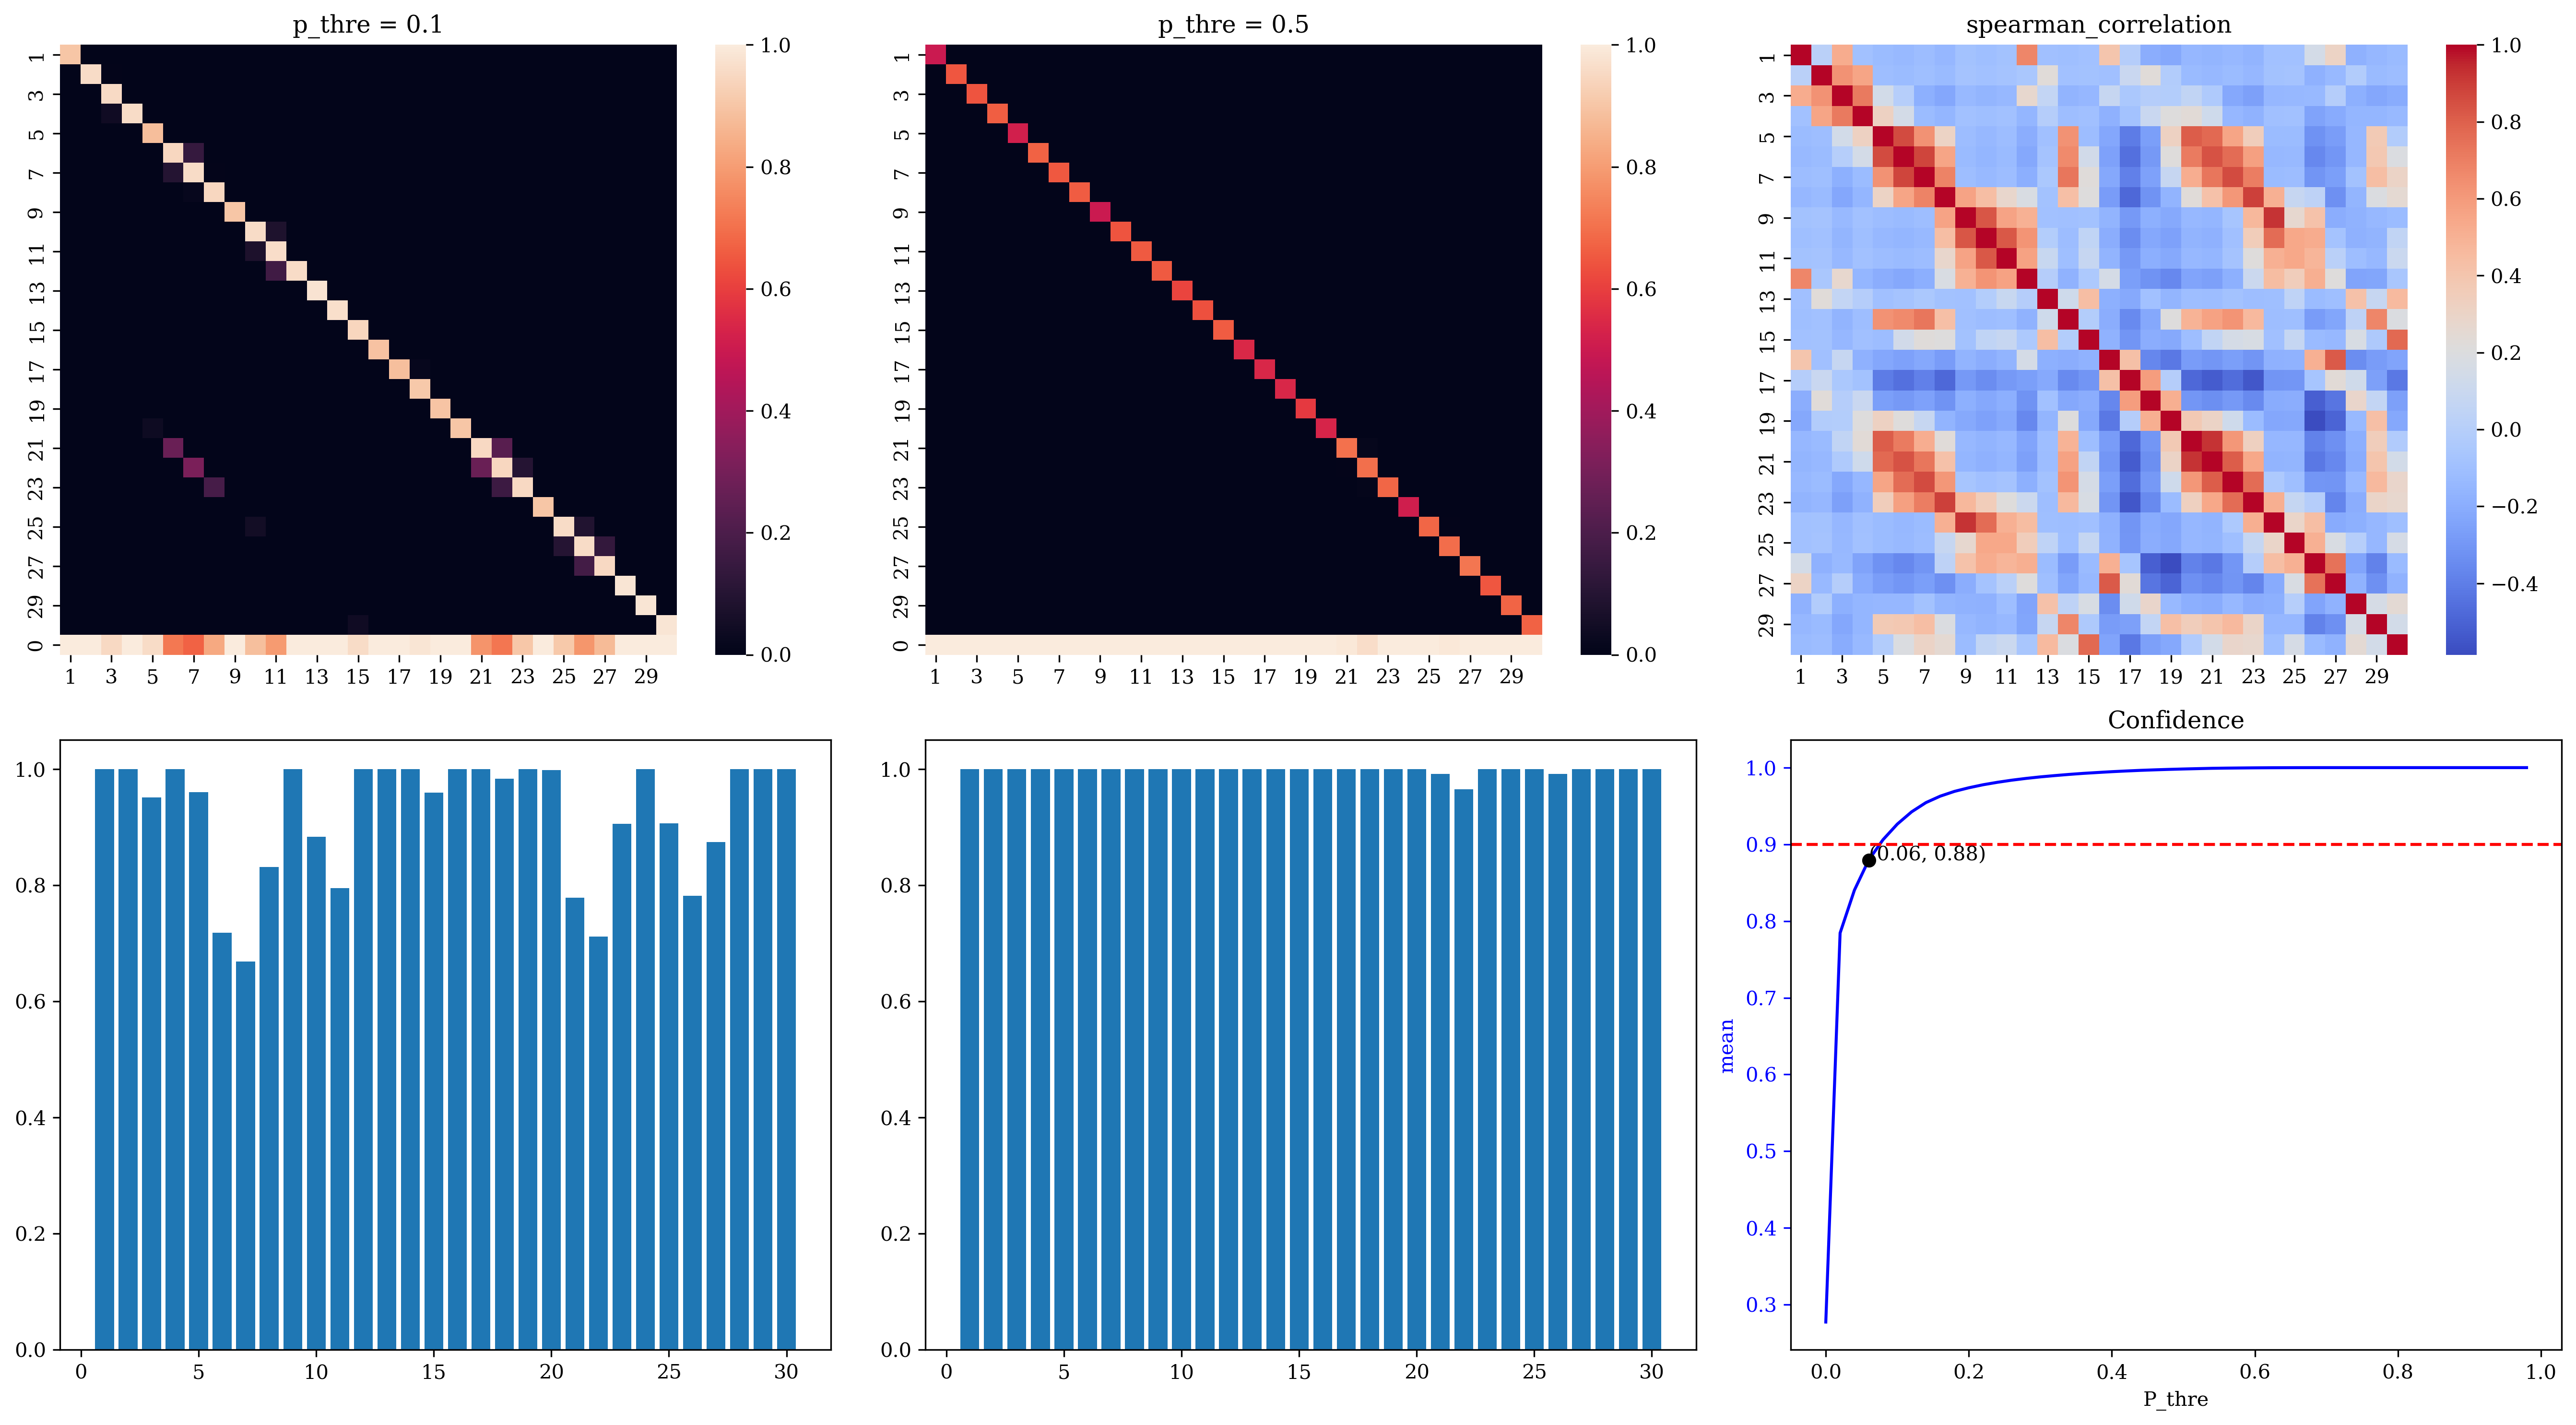

In [29]:
p_thre_list = [0.1, 0.5]
accuracy = []
corr_method = 'spearman'

fig, ax = plt.subplots(nrows=2, ncols=len(p_thre_list) + 1, figsize=(6 * (len(p_thre_list)+1) , 5 * 2))

cdfs_df = cdf_4d.copy()
X_sub = intensity.copy()
ax_heat = ax[0, -1]

corr_matrix = cdfs_df.corr(method=corr_method)
sns.heatmap(corr_matrix, ax=ax_heat, cmap='coolwarm')

ax_heat.set_title(f'{corr_method}_correlation')

for _, p_thre in tqdm(enumerate(p_thre_list), total=len(p_thre_list), desc='p_thre'):
    overlap = pd.DataFrame()

    for cluster_num in range(1, GLAYER*Q_NUM+1):
        tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
        overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)
        
    add = np.diag(overlap) / overlap.sum(axis=0)
    ax[1, _].bar(add.index, add.values)
    accuracy.append(np.mean(add))
    overlap = pd.concat([overlap, pd.DataFrame(add).T], axis=0)

    ax_tmp = ax[0, _]
    ax_tmp.set_title(f'p_thre = {p_thre}')

    sns.heatmap(overlap, vmin=0, vmax=1, ax=ax_tmp)


accuracy, x_intercepts, y_intercepts = plot_mean_accuracy(cdfs_df, X_sub, sample=100, y_line=0.9, total_num=GLAYER*Q_NUM, 
                                                          out_path=read_dir / 'figures' / 'accuracy.png', ax=ax[-1, -1])
plt.tight_layout()
plt.savefig(figure_dir / 'accuracy.pdf')

# cluster visulization after threshold

## threshold

In [30]:
thre = x_intercepts

thre_index = []
cdfs_df = cdf_4d.copy()
for cluster_num in range(1, GLAYER*Q_NUM+1):
    tmp = cdf_4d.loc[intensity['label'][intensity['label']==(cluster_num)].index]
    tmp = tmp[tmp[cluster_num]>thre]
    thre_index += list(tmp.index)

thre_index.sort()
thre_index = pd.Index(thre_index)
thre_index = thre_index.unique()

print(f'thre={thre}\tpoints_kept: {len(thre_index) / len(intensity_raw) * 100 :.1f}%')

thre=0.06	points_kept: 79.7%


## visualization of threshold data

In [31]:
visualization(intensity.loc[thre_index], G_layer=GLAYER, num_per_layer=Q_NUM, 
              colormap_dict=colormap, bins=[500, 500], percentile_thre=99, 
              out_path_dir=figure_dir / 'ColorSpace_selected.png', label=True)

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


## projection and export to image files

In [33]:
data = intensity.loc[thre_index]
if PRISM_PANEL in ['PRISM64', 'PRISM31']:
    if PRISM_PANEL == 'PRISM64': intensity_G['label'] = 64
    elif PRISM_PANEL == 'PRISM31': intensity_G['label'] = 31
    data = pd.concat([data, intensity_G], axis=0)

In [ ]:
# gene_info = pd.read_csv(src_dir / 'gene_list.csv',index_col=0)
# gene_list = gene_info['gene'].tolist()
mapped_genes = data[['Y', 'X', 'label']]
# mapped_genes['Gene'] = mapped_genes['label'].apply(lambda x: gene_list[x-1])
mapped_genes['Gene'] = mapped_genes['label']
mapped_genes = mapped_genes[['X', 'Y', 'Gene']]
mapped_genes[['Y', 'X', 'Gene']].to_csv(read_dir / 'mapped_genes.csv')
mapped_genes

# visualization of rays

In [41]:
# GLAYER = 2
fig = plt.figure(figsize=(10, GLAYER*5))
for i in range(GLAYER):
    tmp = intensity[intensity['G_layer']==i].sample(100000)
    x = tmp['R']
    y = tmp['Ye']
    z = tmp['B']
    
    # 创建3D散点图
    ax1 = fig.add_subplot(GLAYER, 2, 2*i+1, projection='3d')
    scatter = ax1.scatter(x, y, z, c=tmp['label'], alpha=0.05, s=0.1, cmap='prism')
    ax1.set_xlabel('R')
    ax1.set_ylabel('Ye')
    ax1.set_zlabel('B')
    ax1.view_init(30, 45)
    ax1.set_xlim([0, 5000])
    ax1.set_ylim([0, 5000])
    ax1.set_zlim([0, 5000])
    ax1.set_title(f'G={i}')

    # 为第二位的子图设置直方图
    ax2 = fig.add_subplot(GLAYER, 2, 2*i+2)
    for label in np.unique(tmp['label']): 
        sns.histplot(tmp[tmp['label']==label]['sum'], bins=100, alpha=0.05, kde=True, stat='density', edgecolor=None, ax=ax2)
    ax2.set_xlim([500, 5000])
    ax2.set_ylim([0, 0.003])
    ax2.legend(np.unique(tmp['label']))

# plt.tight_layout()
plt.savefig(figure_dir / 'ColorSpace_3d_and_sum_evaluation.png', bbox_inches='tight', dpi=300)
plt.close()